In [ ]:
# Converting notebook to html

!jupyter nbconvert --to html /content/hw3.ipynb

[NbConvertApp] Converting notebook /content/hw3.ipynb to html
[NbConvertApp] Writing 1313597 bytes to /content/hw3.html


# Web Scraping Practice Example Using 교보문고 Bestseller chart
---
## Bykova Nadezhda 2021-28011


#### I did want to use 교보문고 website for this assignment from the very begininng, but was initially planning to use the bestseller section displayed on the main website (screenshot attached below). However, I have discovered that the website that the data for this ranking to be constructed was pulled from had way more abundant data displayed and included a longer rating (19 items displayed instead of 10 per page) for various categories. Therefore, even though I did keep an idea to use the bestseller rating as my data source, I changed the source URL to work with.

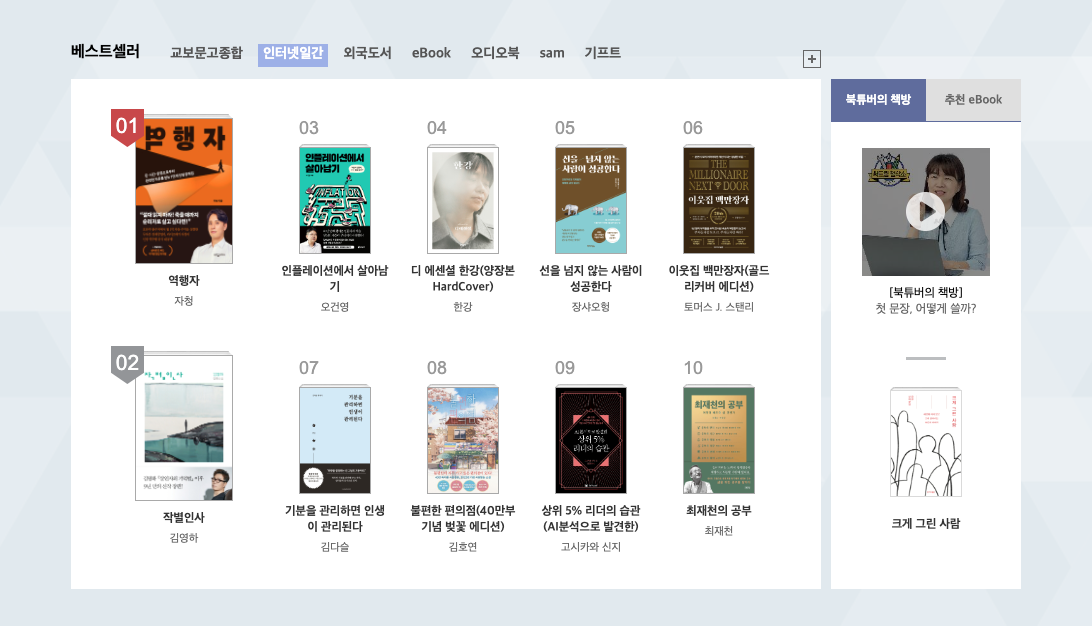

### The webpage I ended up working with is displayed below. My initial aim was to scrape as much valuable data about each book as I could and do so for all the existent categories of bestseller rankings displayed at the top of the webpage (also presented below).

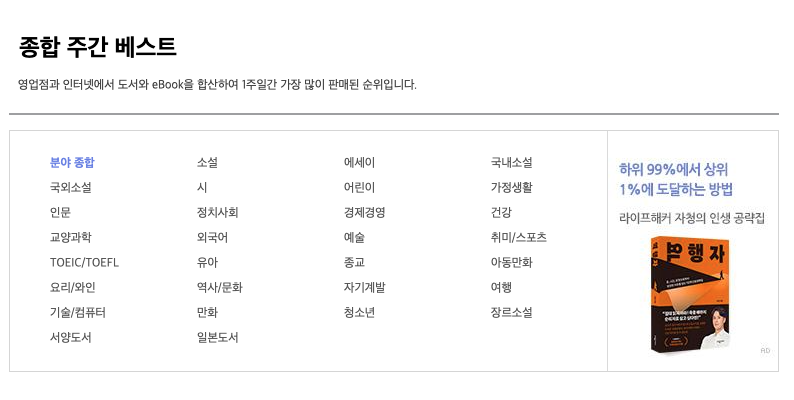

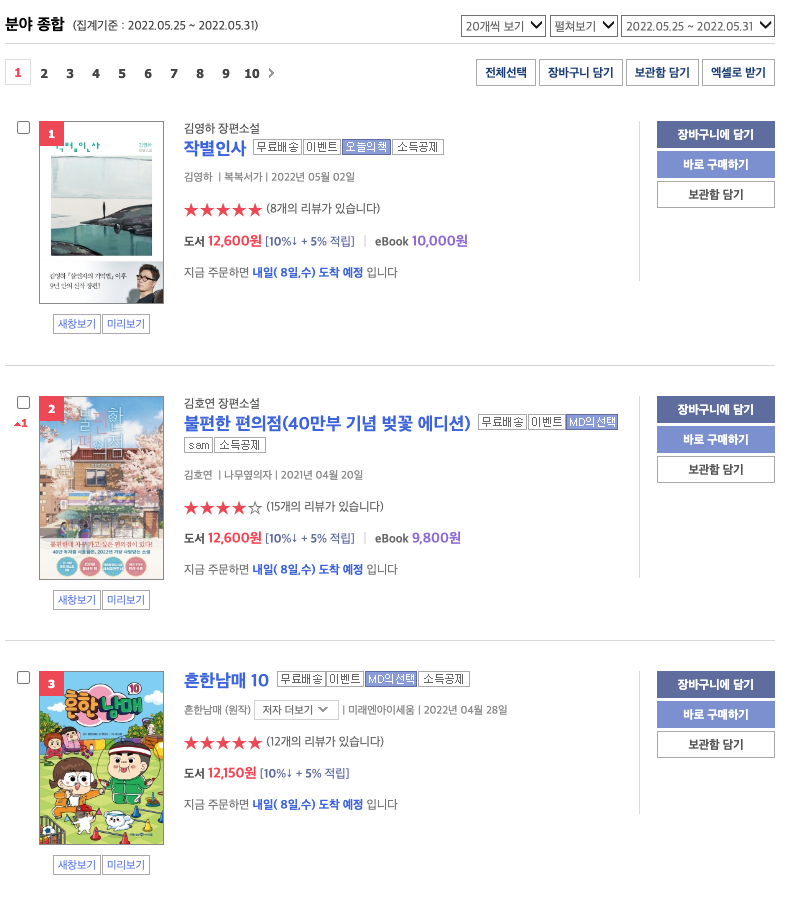

In [ ]:
# Importing the necessary packages
import requests
from bs4 import BeautifulSoup
import re
import pandas
import matplotlib.pyplot as plt
import seaborn as sea

In [ ]:
# Creating a separate list of category names to later assign to scraped data
URL_categories = 'http://www.kyobobook.co.kr/bestSellerNew/bestseller.laf?orderClick=4da'
page = requests.get(URL_categories)
bs = BeautifulSoup(page.text, 'html.parser')
#Product Category
bs_categories  = bs.find(class_ = 'list_sub_category').find_all('a')
categories = []
for category in bs_categories:
  category = category.get_text().replace('\t','').replace('\r','').strip().split('\n')
  categories.append(category)
else:
  categories.pop(27) # Category #27 is ommited to be processed separately (explained in detail below)
print(categories)

[['분야 종합'], ['소설'], ['에세이'], ['국내소설'], ['국외소설'], ['시'], ['어린이'], ['가정생활'], ['인문'], ['정치사회'], ['경제경영'], ['건강'], ['교양과학'], ['외국어'], ['예술'], ['취미/스포츠'], ['TOEIC/TOEFL'], ['유아'], ['종교'], ['아동만화'], ['요리/와인'], ['역사/문화'], ['자기계발'], ['여행'], ['기술/컴퓨터'], ['만화'], ['청소년'], ['서양도서'], ['일본도서']]


In [ ]:
# I have disocovered that the only thing that changed in the URL address for each of the category is a single letter.
# Thus, to save time I have created a list of those and designed the code in such a way to let it collect data for all the categories at once.
# The URL is slightly different for the very first category which is why it is processed separately (it has 'DAa' at the end, not the 'DAb' like other URLs)

list = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'Q', 'R', 'S', 'T', 'U', 'V', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h','i']
for i in list:
  if i == 'A':
    URL = 'http://www.kyobobook.co.kr/bestSellerNew/bestseller.laf?mallGb=KOR&linkClass={}&range=1&kind=0&orderClick=DAa'.format(i)
  else:
    URL = 'http://www.kyobobook.co.kr/bestSellerNew/bestseller.laf?mallGb=KOR&linkClass={}&range=1&kind=0&orderClick=DAb'.format(i)
  page = requests.get(URL)
  bs = BeautifulSoup(page.text, 'html.parser')

  # Product Link
  bs_links = bs.find(class_ = 'list_type01').find_all(class_ = 'title')
  links = []
  for link in bs_links:
    links.append(link.find('a').attrs['href'])

  # Title
  bs_titles  = bs.find(class_ = 'list_type01').find_all(class_ = 'title')
  titles = []
  for title in bs_titles:
    titles.append(title.get_text().strip().split('\n'))

  # Subtitle
  bs_sub_titles  = bs.find(class_ = 'list_type01').find_all(class_ = 'detail')
  sub_titles = []
  for sub_title in bs_sub_titles:
    if sub_title.find(class_ = 'subtitle') is not None: # Necessary because a lot of itimes don't have a subtitle
      sub_title = sub_title.find(class_ = 'subtitle').get_text().replace('\t', '').replace('\r', '').strip().split('\n')
      sub_titles.append(sub_title)
    else:
      sub_title = None
      sub_titles.append(sub_title)

  # Author
  bs_authors  = bs.find(class_ = 'list_type01').find_all(class_ = 'author')
  authors = []
  for author in bs_authors:
    authors.append(author.get_text().replace('\r', '').strip().split('\n')[0])

  # Date Published
  bs_dates  = bs.find(class_ = 'list_type01').find_all(class_ = 'author')
  dates  = []
  for date in bs_dates:
    date = date.get_text().replace('\t', '').strip().split('\n')[-1]
    dates.append(date[2:])

  # Publisher
  bs_publishers  = bs.find(class_ = 'list_type01').find_all(class_ = 'author')
  publishers  = []
  for publisher in bs_publishers:
    publisher = publisher.get_text().replace('\t', '').replace('\r', '').strip().split('\n')[-3]
    publishers.append(publisher[2:])

  # Number of reviews
  bs_reviews_count  = bs.find(class_ = 'list_type01').find_all(class_ = 'review')
  reviews_count = []
  for review_count in bs_reviews_count:
    str = review_count.find('a').get_text()
    x = re.findall('[0-9]+', str) # Finding numeric values in a string for simplicity
    review_count = int(x[0])
    reviews_count.append(review_count)

  # Review star rating (out of 5 stars)
  bs_reviews_star  = bs.find(class_ = 'list_type01').find_all(class_ = 'review')
  reviews_star = []
  for review_star in bs_reviews_star:
    reviews_star.append(review_star.find('img').attrs['alt'][-2])

  # Price
  bs_prices  = bs.find(class_ = 'list_type01').find_all(class_ = 'book_price')
  prices = []
  for price in bs_prices:
    prices.append(int(price.get_text()[:-1].replace(',', '')))

  # Price Ebook
  bs_prices_e  = bs.find(class_ = 'list_type01').find_all(class_ = 'price')
  prices_e = []
  for price_e in bs_prices_e:
    if price_e.find(class_ = 'ebook_price') is not None:
      str = price_e.find('a').get_text().replace(',', '')
      x = re.findall('[0-9]+', str)
      price_e = x[0]
      prices_e.append(price_e)
    else:
      price_e = None
      prices_e.append(price_e)

  # Discount rate (meaning the price was down by this percentage) and how much point percentage collected is
  bs_dcs  = bs.find(class_ = 'list_type01').find_all(class_ = 'dc_rate')
  dcs_change = []
  dcs_save = [] #적립
  for dc in bs_dcs:
    str = dc.get_text()
    x = re.findall('[0-9]+', str)
    dc_change = int(x[0])
    dc_save = int(x[1])
    dcs_change.append(dc_change)
    dcs_save.append(dc_save)

  # Delivery Dates
  delivery_month = []
  delivery_day = []
  bs_delivery = bs.find(class_ = 'list_type01').find_all('div', 'detail')
  for deliv in bs_delivery:
    if deliv.find(class_ = 'blue') is not None:
      deliv = deliv.find('div', 'info').find(class_ = 'blue')
      str = deliv.get_text()
      x = re.findall('[0-9]+', str)
      if len(x) > 1: #Sometimes it says that the book will be delivered tomorrow/the day after tomorrow, in such cases month is not displayed and assumed to be June
        d_m = int(x[0])
        d_d = int(x[1])
      else:
        d_m = 6
        d_d = int(x[0])
      delivery_month.append(d_m)
      delivery_day.append(d_d)
    else:
      d_m = None
      d_d = None
      delivery_month.append(d_m)
      delivery_day.append(d_d)

  # Additional promotion information (displayed as icons)
  bs_icons  = bs.find(class_ = 'list_type01').find_all(class_ = 'icon')
  icons = []
  for icon in bs_icons:
    icon_imgs = icon.find_all('img')
    list_icon = []
    for i_m in icon_imgs:
      i_m = i_m.attrs['alt']
      list_icon.append(i_m)
    icons.append(list_icon)

  # Creating a dataset out of scraped data
  df = pandas.DataFrame({'Category': categories[list.index(i)]*20,
  'Link': links,
  'Title': titles,
  'Subtitle': sub_titles,
  'Author': authors,
  'Date Published': dates,
  'Publisher': publishers,
  'Number of Reviews': reviews_count,
  'Star Rating': reviews_star,
  'Price': prices,
  'Price E-book': prices_e,
  'Price drop': dcs_change,
  'Points Collected (%)': dcs_save,
  'Expected delivery (month)': delivery_month,
  'Expected delivery (day)': delivery_day,
  'Promotion': icons})

  if i == 'A':
    df_full = df
  else:
    df_full = df_full.append(df, ignore_index = True)

df_full['Title'] = df_full['Title'].str[0]
df_full['Subtitle'] = df_full['Subtitle'].str[0]


### Let's take a look at what the dataframe looks like right now. There is a total of 580 observations (meaning books) and 16 columns with data about those. I've left the 'Data Published' column as it was presented on the website, but transformed the 'Expected Delivery Date' column to show that it can be done both ways. I will later work with 'Data Published' colum to show how such data can be used. The processing time was already getting quite slow which is why I only scraped data on the first 20 items for each category.

In [ ]:
df_full

,Category,Link,Title,Subtitle,Author,Date Published,Publisher,Number of Reviews,Star Rating,Price,Price E-book,Price drop,Points Collected (%),Expected delivery (month),Expected delivery (day),Promotion
0,분야 종합,http://www.kyobobook.co.kr/product/detailViewK...,작별인사,김영하 장편소설,김영하,2022년 05월 02일,복복서가,8,5,12600,10000,10,5,6,8,"[무료배송, 이벤트, 오늘의책, 소득공제]"
1,분야 종합,http://www.kyobobook.co.kr/product/detailViewK...,불편한 편의점(40만부 기념 벚꽃 에디션),김호연 장편소설,김호연,2021년 04월 20일,나무옆의자,15,4,12600,9800,10,5,6,8,"[무료배송, 이벤트, MD의 선택, sam, 소득공제]"
2,분야 종합,http://www.kyobobook.co.kr/product/detailViewK...,흔한남매 10,,흔한남매 (원작),2022년 04월 28일,미래엔아이세움,12,5,12150,None,10,5,6,8,"[무료배송, 이벤트, MD의 선택, 소득공제]"
3,분야 종합,http://www.kyobobook.co.kr/product/detailViewK...,인플레이션에서 살아남기,"애프터 인플레, 누가 돈을 벌까?",오건영,2022년 05월 23일,페이지2북스,1,3,16920,13000,10,5,6,8,"[무료배송, 이벤트, 오늘의책, sam, 소득공제]"
4,분야 종합,http://www.kyobobook.co.kr/product/detailViewK...,역행자,돈.시간.운명으로부터 완전한 자유를 얻는 7단계 인생 공략집,자청,2022년 05월 30일,웅진지식하우스,3,5,15750,11070,10,5,6,8,"[무료배송, 이벤트, 오늘의책, 소득공제]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
575,일본도서,http://www.kyobobook.co.kr/product/detailViewE...,모노마스터 MONOMASTER 2022.06 (마모트 커틀러리 멀티툴),,寶島社,2022년 04월 25일,寶島社,0,0,13000,None,0,2,6,8,"[무료배송, 정가제free]"
576,일본도서,http://www.kyobobook.co.kr/product/detailViewE...,스마트 SMART 2022.04 (A BATHING APE 수납 컨테이너박스),,寶島社,2022년 02월 25일,寶島社,0,0,11800,None,2,2,6,8,"[무료배송, 이벤트, 한정판매, 정가제free]"
577,일본도서,http://www.kyobobook.co.kr/product/detailViewE...,"台所の工夫と,道具選び.",,マガジンハウス,2022년 05월 01일,マガジンハウス,0,0,17690,None,10,0,6,9,"[무료배송, 소득공제, 정가제free]"
578,일본도서,http://www.kyobobook.co.kr/product/detailViewE...,僕らのニッポン小旅行案內. LET'S TAKE A SHORT TRIP!,,マガジンハウス,2022년 04월 26일,マガジンハウス,0,0,14220,None,10,0,6,9,"[무료배송, 소득공제, 정가제free]"


### In regards to the category that I purposely missed, it was the '장르소설' one. The URL it uses is slightly different from the others (because it uses 'DBk', 'EBK' and especially because it uses '08' instead of a letter). More importantly, the data on books from this category was rather different: because most of the entities are E-books, for instance, the price that is recorded as price is actually the E-book price. Additionally, those don't have any special promotion tags, star ratings and delivery dates. The only data we can get is: title, author, date published, E-book price, drop in price and collected point percentage. I decided to proceed and save data on these entities in a separate dataframe. I will also merge it with the one previously created just to show that it is possible to have one final dataset and work with it.



In [ ]:
URL_2 = 'http://www.kyobobook.co.kr/bestSellerNew/bestseller.laf?mallGb=EBK&linkClass=08&range=1&kind=0&orderClick=DBk'
page_2 = requests.get(URL_2)
bs_2 = BeautifulSoup(page_2.text, 'html.parser')

# Product Link
bs_2_links  = bs_2.find(class_ = 'list_type01').find_all(class_ = 'title')
links_2 = []
for link_2 in bs_2_links:
  links_2.append(link_2.find('a').attrs['href'])

#Title
bs_2_titles  = bs_2.find(class_ = 'list_type01').find_all(class_ = 'title')
titles_2 = []
for title_2 in bs_2_titles:
  titles_2.append(title_2.get_text().strip().split('\n'))

# Author
bs_2_authors  = bs_2.find(class_ = 'list_type01').find_all(class_ = 'author')
authors_2 = []
for author_2 in bs_2_authors:
  authors_2.append(author_2.get_text().replace('\r', '').strip().split('\n')[0])

# Date Published
bs_2_dates  = bs_2.find(class_ = 'list_type01').find_all(class_ = 'author')
dates_2  = []
for date_2 in bs_2_dates:
  date_2 = date_2.get_text().replace('\t', '').strip().split('\n')[-1]
  dates_2.append(date_2[2:])

# Publisher
bs_2_publishers  = bs_2.find(class_ = 'list_type01').find_all(class_ = 'author')
publishers_2  = []
for publisher_2 in bs_2_publishers:
  publisher_2 = publisher_2.get_text().replace('\t', '').replace('\r', '').strip().split('\n')[-3]
  publishers_2.append(publisher_2[2:])

# Price (E-book price)
bs_2_prices  = bs_2.find(class_ = 'list_type01').find_all(class_ = 'book_price')
prices_2 = []
for price_2 in bs_2_prices:
  prices_2.append(int(price_2.get_text()[:-1].replace(',', '')))

# Discount rate (meaning the price was down by this percentage) and how much point percentage collection is
bs_2_dcs  = bs_2.find(class_ = 'list_type01').find_all(class_ = 'dc_rate')
dcs_change_2 = []
dcs_save_2 = []
for dc_2 in bs_2_dcs:
  str_2 = dc_2.get_text()
  x_2 = re.findall('[0-9]+', str_2)
  dc_change_2 = int(x_2[0])
  dc_save_2 = int(x_2[1])
  dcs_change_2.append(dc_change_2)
  dcs_save_2.append(dc_save_2)

# Creating a dataset out of scraped data
# The missing columns are left empty values to keep the number of columns equal to that of the above dataset for a later merge.

df_2 = pandas.DataFrame({'Category': '장르소설',
  'Link': links_2,
  'Title': titles_2, # I left the [E-book] sign as it is, but it can be removed
  'Subtitle': '',
  'Author': authors_2,
  'Date Published': dates_2,
  'Publisher': publishers_2,
  'Number of Reviews': '',
  'Star Rating': '',
  'Price': '',
  'Price E-book': prices_2,  # Notice that price is recorded as price for an E-book
  'Price drop': dcs_change_2,
  'Points Collected (%)': dcs_save_2,
  'Expected delivery (month)': '',
  'Expected delivery (day)': '',
  'Promotion': ''})

df_2['Title'] = df_2['Title'].str[0]

In [ ]:
df_2

,Category,Link,Title,Subtitle,Author,Date Published,Publisher,Number of Reviews,Star Rating,Price,Price E-book,Price drop,Points Collected (%),Expected delivery (month),Expected delivery (day),Promotion
0,장르소설,http://digital.kyobobook.co.kr/digital/ebook/e...,[eBook] 닥터 플레이어. 20(완결),,유인(流人),2022년 04월 14일,KW북스,,,,2880,10,5,,,
1,장르소설,http://digital.kyobobook.co.kr/digital/ebook/e...,[eBook] 이세계서 유부남된 썰. 12(완결),,베르헤라,2022년 04월 15일,문피아,,,,2880,10,5,,,
2,장르소설,http://digital.kyobobook.co.kr/digital/ebook/e...,[eBook] 강남 큰손 이야기. 20(완결),,악중선,2018년 12월 06일,문피아,,,,2880,10,5,,,
3,장르소설,http://digital.kyobobook.co.kr/digital/ebook/e...,[eBook] 수의사 드루이드. 13(완결),,서건주,2022년 05월 18일,파피루스,,,,2880,10,5,,,
4,장르소설,http://digital.kyobobook.co.kr/digital/ebook/e...,[eBook] 검신재생. 13(완결),,밀렵,2022년 05월 18일,파피루스,,,,2880,10,5,,,
5,장르소설,http://digital.kyobobook.co.kr/digital/ebook/e...,[eBook] 추방당한 각성자는 행복을 꿈꾼다. 외전 2,,제법넓은강,2022년 04월 03일,라이노,,,,2880,10,5,,,
6,장르소설,http://digital.kyobobook.co.kr/digital/ebook/e...,[eBook] 보이스피싱인데 인생역전. 21(외전),,장탄,2020년 10월 30일,문피아,,,,2880,10,5,,,
7,장르소설,http://digital.kyobobook.co.kr/digital/ebook/e...,[eBook] 전왕. 22,,건드리고고,2022년 05월 06일,영상출판미디어(영상노트),,,,3150,10,5,,,
8,장르소설,http://digital.kyobobook.co.kr/digital/ebook/e...,[eBook] 슬기로운 배우생활. 14(완결),,천구머니,2022년 05월 02일,문피아,,,,2880,10,5,,,
9,장르소설,http://digital.kyobobook.co.kr/digital/ebook/e...,[eBook] 신의 마법사. 10(완결),,오늘도요,2022년 04월 14일,KW북스,,,,2880,10,5,,,


In [ ]:
# How the two datasets can be merged
both = [df_full, df_2]
df_merged = pandas.concat(both)

In [ ]:
df_merged # Now there are 600 rows instead of 520

,Category,Link,Title,Subtitle,Author,Date Published,Publisher,Number of Reviews,Star Rating,Price,Price E-book,Price drop,Points Collected (%),Expected delivery (month),Expected delivery (day),Promotion
0,분야 종합,http://www.kyobobook.co.kr/product/detailViewK...,작별인사,김영하 장편소설,김영하,2022년 05월 02일,복복서가,8,5,12600,10000,10,5,6,8,"[무료배송, 이벤트, 오늘의책, 소득공제]"
1,분야 종합,http://www.kyobobook.co.kr/product/detailViewK...,불편한 편의점(40만부 기념 벚꽃 에디션),김호연 장편소설,김호연,2021년 04월 20일,나무옆의자,15,4,12600,9800,10,5,6,8,"[무료배송, 이벤트, MD의 선택, sam, 소득공제]"
2,분야 종합,http://www.kyobobook.co.kr/product/detailViewK...,흔한남매 10,,흔한남매 (원작),2022년 04월 28일,미래엔아이세움,12,5,12150,None,10,5,6,8,"[무료배송, 이벤트, MD의 선택, 소득공제]"
3,분야 종합,http://www.kyobobook.co.kr/product/detailViewK...,인플레이션에서 살아남기,"애프터 인플레, 누가 돈을 벌까?",오건영,2022년 05월 23일,페이지2북스,1,3,16920,13000,10,5,6,8,"[무료배송, 이벤트, 오늘의책, sam, 소득공제]"
4,분야 종합,http://www.kyobobook.co.kr/product/detailViewK...,역행자,돈.시간.운명으로부터 완전한 자유를 얻는 7단계 인생 공략집,자청,2022년 05월 30일,웅진지식하우스,3,5,15750,11070,10,5,6,8,"[무료배송, 이벤트, 오늘의책, 소득공제]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15,장르소설,http://digital.kyobobook.co.kr/digital/ebook/e...,[eBook] 영업사원 입니다만. 8(완결),,마인네스,2022년 04월 18일,문피아,,,,2880,10,5,,,
16,장르소설,http://digital.kyobobook.co.kr/digital/ebook/e...,[eBook] 어서와요 한류식당. 9(완결),,은빛선,2022년 04월 26일,문피아,,,,2880,10,5,,,
17,장르소설,http://digital.kyobobook.co.kr/digital/ebook/e...,[eBook] 딜레탕트(Dilettante)(삽화본). 2,,진소예,2022년 04월 22일,윤송스피넬,,,,3100,0,5,,,
18,장르소설,http://digital.kyobobook.co.kr/digital/ebook/e...,"[eBook] 마이, 마이 라이프!. 16",,파셔,2018년 09월 28일,제이플러스미디어,,,,2250,10,5,,,


### There was something else I initially wanted to do. I wanted to use the links that are already there in the dataset to scrape more data about each book. I included the code to do so in the above code chunk, but it was taking over 20 minutes to process (for each of the 600 entries a new url had to be opened, then data was scraped). In order to demostrate what the idea was I include a little demonstration code below. It only works with the first book category (meaning only 20 books), uses the scraped URL to open a book-specific webpage and scrapes ISBN (ISBN 13) index for a book. I then proceed to make a dataset that contains the initially scraped URL and ISBN index that is scraped on the second stage of the process. If the processing power allowed me to do so for all the entities above, number of pages, size of the book, key words and more information about each one of those could be retrieved.

In [ ]:
URL_demo = 'http://www.kyobobook.co.kr/bestSellerNew/bestseller.laf?mallGb=KOR&linkClass=A&range=1&kind=0&orderClick=DAa'
page_demo = requests.get(URL_demo)
bs_demo = BeautifulSoup(page_demo.text, 'html.parser')

# Product Link
bs_links_demo  = bs_demo.find(class_ = 'list_type01').find_all(class_ = 'title')
links_demo = []
ISBN_demo = []
for link_demo in bs_links_demo:
  links_demo.append(link_demo.find('a').attrs['href'])
for link_demo in links_demo:
  URL_demo_ISBN = link_demo
  page_demo_ISBN = requests.get(URL_demo_ISBN) # Scraped link now becomes a new URL
  bs_demo_ISBN = BeautifulSoup(page_demo_ISBN.text, 'html.parser')

  bs_demo_ISBN_find  = bs_demo_ISBN.find(class_ = 'table_simple2 table_opened margin_top10').find("span", {"title": "ISBN-13"})
  ISBN_demo.append(bs_demo_ISBN_find.get_text())

# Title

bs_titles_demo  = bs_demo.find(class_ = 'list_type01').find_all(class_ = 'title')
titles_demo = []
for title_demo in bs_titles_demo:
  titles_demo.append(title_demo.get_text().strip().split('\n'))

# Creating the dataframe

df_demo = pandas.DataFrame({'Link': links_demo,
                            'ISBN-13': ISBN_demo,
                            'Title': titles_demo})
df_demo['Title'] = df_demo['Title'].str[0]


In [ ]:
df_demo # Other columns were omitted for the sake of simplyfying the demonstration

,Link,ISBN-13,Title
0,http://www.kyobobook.co.kr/product/detailViewK...,9791191114225,작별인사
1,http://www.kyobobook.co.kr/product/detailViewK...,9791161571188,불편한 편의점(40만부 기념 벚꽃 에디션)
2,http://www.kyobobook.co.kr/product/detailViewK...,9791168411685,흔한남매 10
3,http://www.kyobobook.co.kr/product/detailViewK...,9791190977661,인플레이션에서 살아남기
4,http://www.kyobobook.co.kr/product/detailViewK...,9788901260716,역행자
5,http://www.kyobobook.co.kr/product/detailViewK...,9791196617127,기분을 관리하면 인생이 관리된다
6,http://www.kyobobook.co.kr/product/detailViewK...,9791191347685,마음의 법칙
7,http://www.kyobobook.co.kr/product/detailViewK...,9791157845798,변화하는 세계 질서
8,http://www.kyobobook.co.kr/product/detailViewK...,9788932922362,행성 1(양장본 HardCover)
9,http://www.kyobobook.co.kr/product/detailViewK...,9791164455676,문재인의 위로(양장본 HardCover)


In [ ]:
# Now that we got all of out datasets, we can save them as csv files and proceed with the analysis
df_full.to_csv('kyobo_full.csv', index = False)
df_merged.to_csv('kyobo_merged.csv', index = False)

### Several simply examples of how the scraped data can be used for analysis are presented in what follows.

In [ ]:
# Question: Who are the TOP-10 most popular publishers among the TOP20 bestsellers in all categories?
df_merged.groupby(['Publisher'])['Link'].count().sort_values(ascending = False).head(10)

Publisher
해커스어학연구소           21
문학동네               16
모모                 12
창비                 12
미래엔아이세움            11
김영사                10
서울미디어코믹스(서울문화사)     8
더퀘스트                7
寶島社                 7
팩토리나인               7
Name: Link, dtype: int64

In [ ]:
# Question: Who are the most TOP10 popular authors among the TOP20 bestsellers in all categories?
df_merged.groupby(['Author'])['Link'].count().sort_values(ascending = False).head(10)

Author
David Cho    14
흔한남매 (원작)     7
寶島社           7
マガジンハウス       6
오은영           5
백희나           5
이미예           5
정선근           4
해커스 어학연구소     4
박현숙           3
Name: Link, dtype: int64

In [ ]:
# Question: Who are the TOP10 authors with the highest number of 5/5 rating books?
df_merged['Star Rating'] = pandas.to_numeric(df_merged['Star Rating'])
max_authors = pandas.DataFrame(df_merged.loc[df_merged['Star Rating'] == 5, 'Author'])
max_authors['Author'].value_counts().reset_index().head(10)

,index,Author
0,David Cho,6
1,오은영,5
2,흔한남매 (원작),5
3,김영하,3
4,백희나,3
5,김초엽,3
6,손원평,3
7,최은영,3
8,B. A. 패리스,3
9,김지혜,3


In [ ]:
# Let's take a look at David Cho's books to check if there are six books of his that got the highest rating
df_merged.loc[df_merged['Author'] == 'David Cho']

,Category,Link,Title,Subtitle,Author,Date Published,Publisher,Number of Reviews,Star Rating,Price,Price E-book,Price drop,Points Collected (%),Expected delivery (month),Expected delivery (day),Promotion
264,외국어,http://www.kyobobook.co.kr/product/detailViewK...,그래머 게이트웨이 베이직: 초보를 위한 기초 영문법(Grammar Gateway B...,기초영어 문법 한 달 완성 / 영문법ㆍ영어회화ㆍ영작 동시학습,David Cho,2022년 02월 14일,해커스어학연구소,12,5,13410,None,10,5,6,8,"[무료배송, 이벤트, 소득공제]"
320,TOEIC/TOEFL,http://www.kyobobook.co.kr/product/detailViewK...,해커스 토익 기출 보카 TOEIC VOCA(개정판 5판),주제별 연상암기로 토익 영단어 30일 완성!,David Cho,2022년 03월 14일,해커스어학연구소,8,5,11610,None,10,5,6,8,"[무료배송, 이벤트, 소득공제]"
321,TOEIC/TOEFL,http://www.kyobobook.co.kr/product/detailViewK...,해커스 토익 RC 리딩(Reading)(개정판 8판),"토익리딩의기본서, 문법ㆍ독해ㆍ어휘에서실전까지 | 토익최신기출경향반영",David Cho,2022년 01월 10일,해커스어학연구소,6,5,16920,None,10,5,6,8,"[무료배송, 이벤트, 소득공제]"
322,TOEIC/TOEFL,http://www.kyobobook.co.kr/product/detailViewK...,해커스 보카(Hackers Vocabulary)(개정판 2판),토플/IELTS/텝스/공무원/SAT/특목고,David Cho,2021년 12월 13일,해커스어학연구소,9,4,15210,None,10,5,6,8,"[무료배송, 이벤트, MD의 선택, 소득공제]"
325,TOEIC/TOEFL,http://www.kyobobook.co.kr/product/detailViewK...,해커스 토익 LC 리스닝(Listening)(개정판 8판),"토익리스닝의기본서, 토익LC기본에서실전까지 | 토익최신기출경향반영",David Cho,2022년 01월 10일,해커스어학연구소,5,5,16920,None,10,5,6,8,"[무료배송, 이벤트, 소득공제]"
326,TOEIC/TOEFL,http://www.kyobobook.co.kr/product/detailViewK...,해커스 토플 리딩(Hackers TOEFL Reading)(4판),,David Cho,2022년 02월 07일,해커스어학연구소,0,0,21510,None,10,5,6,8,"[무료배송, 이벤트, 소득공제]"
327,TOEIC/TOEFL,http://www.kyobobook.co.kr/product/detailViewK...,해커스 토익 스타트 리딩(Reading) RC(개정판 4판),초보를 위한 토익 입문서 | 기초 문법ㆍ어휘ㆍ독해 4주 완성,David Cho,2022년 02월 21일,해커스어학연구소,4,5,13410,None,10,5,6,8,"[무료배송, 이벤트, 소득공제]"
329,TOEIC/TOEFL,http://www.kyobobook.co.kr/product/detailViewK...,해커스 토플 리스닝(Hackers TOEFL Listening)(4판),,David Cho,2022년 04월 04일,해커스어학연구소,0,0,26550,None,10,5,6,8,"[무료배송, 이벤트, 소득공제]"
330,TOEIC/TOEFL,http://www.kyobobook.co.kr/product/detailViewK...,해커스 토익 스타트 리스닝(Listening) LC(개정판 4판),초보를 위한 토익 입문서 | 무료 교재 MP3 제공,David Cho,2022년 02월 21일,해커스어학연구소,3,4,13410,None,10,5,6,8,"[무료배송, 이벤트, 소득공제]"
332,TOEIC/TOEFL,http://www.kyobobook.co.kr/product/detailViewK...,해커스 토플 라이팅(Hackers TOEFL Writing)(4판),,David Cho,2021년 10월 18일,해커스어학연구소,0,0,18810,None,10,5,6,8,"[무료배송, 이벤트, 소득공제]"


In [ ]:
# Question: What is the mean price of TOP20 books within each category? Which category has the highest mean price?
df_merged['Price'] = pandas.to_numeric(df_merged['Price'])
df_merged['Price E-book'] = pandas.to_numeric(df_merged['Price E-book'])
df_merged.groupby(['Category'])['Price'].mean().sort_values(ascending = False)

Category
기술/컴퓨터         22815
예술             19989
요리/와인          18918
역사/문화          17672
교양과학           17118
경제경영           16978
가정생활           16605
건강             16263
TOEIC/TOEFL    16128
취미/스포츠         15732
인문             15669
정치사회           15512
여행             15282
분야 종합          15273
외국어            14724
종교             14620
자기계발           14180
에세이            14022
소설             12866
국외소설           12830
유아             12614
서양도서           12468
국내소설           12424
아동만화           11668
청소년            11344
일본도서           11288
어린이            11218
시              10192
만화              6840
장르소설             NaN
Name: Price, dtype: float64

In [ ]:
# Let's inspect the price difference between paper books and E-books. In which category the mean difference is the highest?
df_merged_test = df_merged
df_merged_test['Price Difference'] = df_merged['Price'] - df_merged['Price E-book']
df_merged_test['Price Difference'] = pandas.to_numeric(df_merged_test['Price Difference'])
df_merged_test.groupby(['Category'])['Price Difference'].mean().sort_values(ascending = False)

Category
예술             4180
분야 종합          3837
기술/컴퓨터         3783
에세이            3581
경제경영           3490
역사/문화          3479
요리/와인          3473
교양과학           3439
건강             3424
자기계발           3397
정치사회           3211
국외소설           3165
인문             3137
가정생활           3126
종교             3001
외국어            2958
취미/스포츠         2900
소설             2767
여행             2730
국내소설           2727
청소년            2629
유아             2400
시              2162
어린이            1736
만화             1650
아동만화           1300
TOEIC/TOEFL     NaN
서양도서            NaN
일본도서            NaN
장르소설            NaN
Name: Price Difference, dtype: float64

In [ ]:
# Let's take out only the year the book was published out of the 'Date Published' column that was scraped as it is. How many books were published in each year?

df_merged['Year Published'] = df_merged['Date Published'].str[:4]
df_merged.groupby(['Year Published'])['Link'].count().sort_values(ascending = False)

Year Published
2022    351
2021     99
2020     35
2019     28
2018     20
2017     17
2014      8
2016      7
2015      7
2013      7
2012      6
2010      5
2011      2
2006      2
2000      1
2009      1
2008      1
2007      1
2005      1
1991      1
Name: Link, dtype: int64

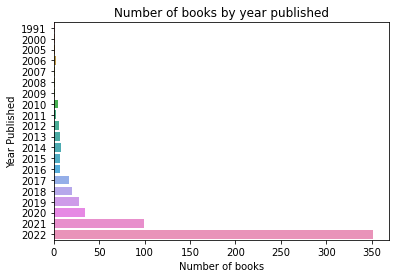

In [ ]:
# A quick example of visualization of the same data

df_merged["Year Published"] = pandas.to_numeric(df_merged["Year Published"])
df_merged["Year Published"].sort_values()

ax_i = sea.countplot(y="Year Published", data=df_merged)
ax_i.set(xlabel='Number of books', ylabel='Year Published', title='Number of books by year published')
plt.show(ax_i)